# Implementing Deep Neural Networks for YouTube Recommendations in PyTorch

---



[Deep Neural Networks for YouTube Recommendations](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf), published in 2016 by Paul Covington, Jay Adams and Emre Sargin, has a great impact on the development of recommendation system. The system has two major components: candidate generation and ranking. 

In this tutorial, I implement the candidate generation system. As YouTube does not release its data, I use MovieLens data set to model it.

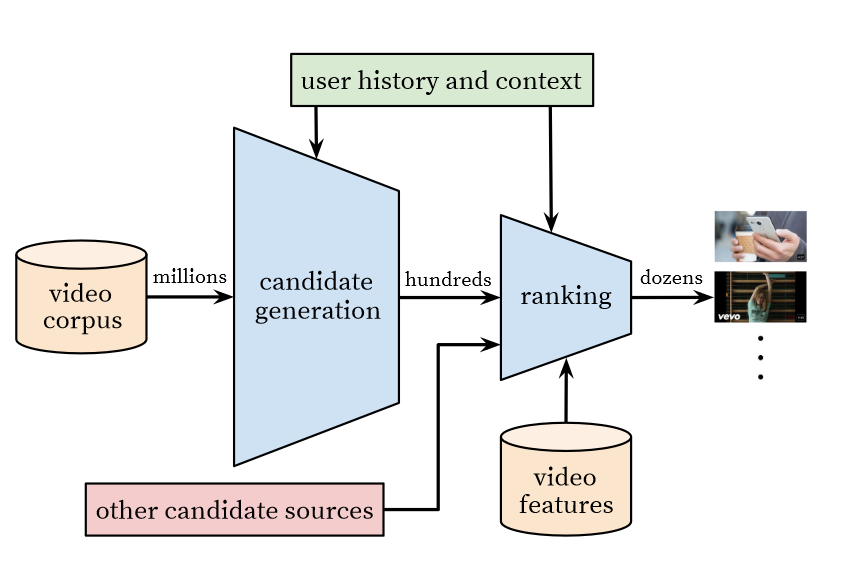

In [1]:
from urllib.request import urlretrieve
import zipfile
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from nltk.tokenize import word_tokenize
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Import data set.
Download the MovieLens data set from its official website. It contains three data sets: *Ratings*, *Users*, *Movies*.

In [3]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

In [4]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', engine='python', header = None, names  = ['user_id','movie_id','rating','timestamp'])
users = pd.read_csv('ml-1m/users.dat', sep = '::', engine='python', header = None, names  = ['user_id', 'gender', 'age', 'occupation', 'zip_code'])
movies = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python', header = None, names=['movie_id', 'title', 'genres'])

The data sets have 1 million ratings rated by 6,000 users on 3,800 movies between 2000-04-25 and 2003-02-28. Let's have a look at the data sets.

In [5]:
print('Ratings:')
print(ratings.head(2))

Ratings:
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109


In [6]:
print('Users:')
print(users.head(2))

Users:
   user_id gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072


In [7]:
print('Movies:')
print(movies.head(2))


Movies:
   movie_id             title                        genres
0         1  Toy Story (1995)   Animation|Children's|Comedy
1         2    Jumanji (1995)  Adventure|Children's|Fantasy


The candidate generation component is illustrated as below:
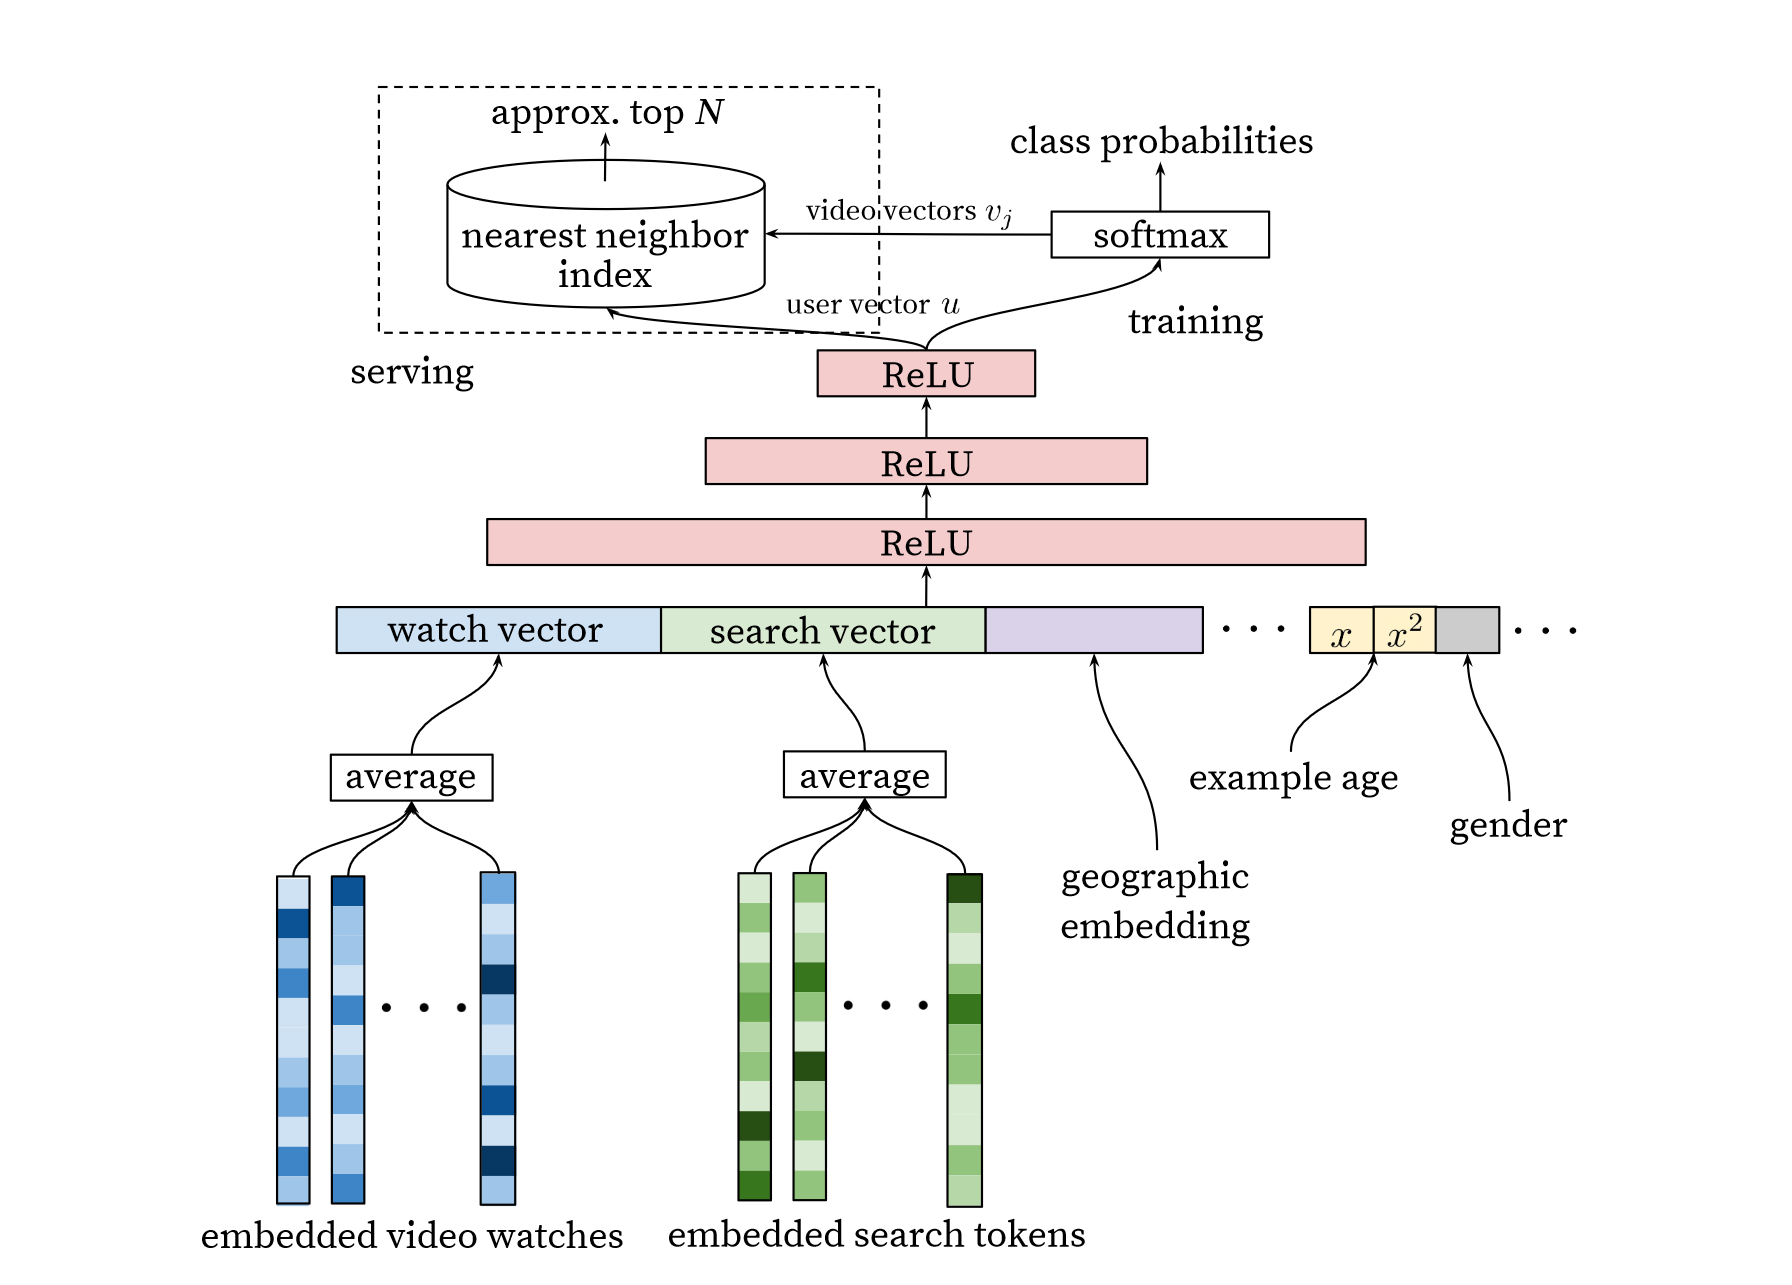



The YouTube paper uses video watches, search history, and user context (such as gender) to train the model. Note that Youtube does not use explicit rating which is extremely sparse. Instead, it uses the implicit feedback of watches, where a user completing a video is a positive example. I model the input information as follows:

*   Video watches: Here I use the rating pairs as evidences that the user has completed the video. Then the movies rated by a user in the *Ratings* data set are considered as the user's video watches. 

*   Search history: The title of a completed movie is taken as the search tokens for that user.

*   User context: the information provided in the *Users* data set, namely gender, age and occupation are used as context variables. 

Example age is in fact an important feature in the YouTube model. Recommending  recently  uploaded content is extremely important for YouTube because users prefer fresh content. However, given that the rating time in the data set was between 2000-04-25 23:05:32 and 2003-02-28 17:49:50, which is a relatively short period. It does not make sense to model the example age using this data set.

# 2. Data preprocessing.

---
## Data preprocessing for search tokens.

[GloVe](https://nlp.stanford.edu/projects/glove/) works better than many other pre-trained word embeddings in a wide range of subsequent NLP tasks. It encodes meaning components in vector differences. Furthermore, it was trained on Wikipedia which is about definitions and explanations of terms, while Google's Word2vec was trained on Google new corpus. So it makes sense that GloVe has better performance. 

I use the GloVe pre-trained word embeddings for the search tokens. Download the glove.6B.zip file [here](https://nlp.stanford.edu/data/glove.6B.zip). 

GloVe pre-trained embeddings come in different dimensions: 50, 100, 200, 300. The number of word embedding dimensions directly affects the number of NN input dimensions. As the number of training examples is not very big, I don't want a huge word embedding dimension. In addition, this is not a pure NLP task. A coarse word embedding is acceptable. Thus, I choose 50 dimensions.  

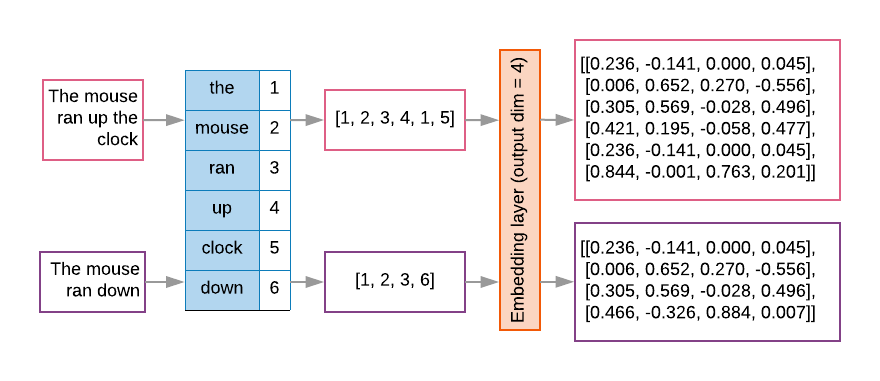
https://developers.google.com/machine-learning/guides/text-classification/images/EmbeddingLayer.png

The word embedding works as follows: 

First we create a vocabulary which includes all the words in the search history (movie titles), and assign an integer index for each word. For example, if the data set has only six words ("the", "mouse", "ran", "up", "clock", "down"), so the vocabulary only has six words, and we assign integers 1-6 as indices for each of them. 

Then we replace the tokens in the data set with their corresponding indices. For example, one search hisory A "the mouse ran up the" is converted to [1, 2, 3, 4, 1]. 

Next, we retrieve the pre-trained embedding vectors from GloVe for each word in the vocabulary and hold them in a embedding matrix shaped [number of words in the vocabulary, number of word embedding dimensions] (i.e. shaped [6,4]). 

The search hisory A [1, 2, 3, 4, 1] is converted to [1_vec, 2_vec, 3_vec, 4_vec, 1_vec] where i_vec is the pre-trained word embedding vector for token i. Now the search history becomes a matrix shaped [number of words in search history A, number of word embedding dimensions] (i.e. shaped [5,4]).

At last, we take the average across the words to get a vector whose length is the number of word embedding dimensions (i.e. 4) as the representation of search hisory A "the mouse ran up the" and feed it into the neural network. By the way, there are other integration methods other than averaging, such as maximum, sum, etc. But for most tasks, averaging works best, because we don't want some extreme words dominate the value of search history.

In this way, no matter how long the search history is (for instance, ["Allan Quartermain and the Lost City of Gold", "Amityville 1992: It's About Time", ...], probably has hundreds of search records and each search record has dozens of tokens), we can reduce it to the fixed number of word embedding dimensions (i.e. 50). Note that only unigram is considered and the Bag of Words assumption is used here.

Let's implement this idea. First, tokenize the movie titles into the "search" column.

In [8]:
def movies_prep(dataset = movies):
  ''' Prepare the movies data set.'''

  # the contents of movies.title column includes years. Extract only movie titles to that column.
  dataset['title'] = dataset.title.str.extract(r'(^[^\(]+)')
  # lowercase
  dataset['title'] = dataset['title'].apply(lambda x: x.lower())
  # tokenize
  dataset['search'] = dataset['title'].apply(lambda x: word_tokenize(x))

  return dataset

movies = movies_prep(movies)
print(movies.head(2))

   movie_id       title                        genres        search
0         1  toy story    Animation|Children's|Comedy  [toy, story]
1         2    jumanji   Adventure|Children's|Fantasy     [jumanji]


Second, create a dictionary: *word_to_index* which maps a word in the vocabulary (all the words appeared in movie titles) to an index. Create another dictionary *index_to_word* holds the reverse. Replace the words with their indices.

In [9]:
def mapping(row, word_to_index):
  '''Sub-function used in map_to_id_list(). '''
  
  i = 0
  while i < len(row):
      row[i] = word_to_index[row[i]]
      i += 1
      
  return row
        

def map_to_id_list(dataset, column):
  ''' 
  Convert a dataset.column whose cell is like ['a', 'story'] to [1, 2], where 1, 2 are the index of 'a', 'story' in 
  the constructed dictionary.
  
  Arguments:
  -- dataset. Name of the dataset.
  -- column name. In string form, e.g. 'user_id'.
  
  Return:
  -- A dictionary mapping {word: index}. 
  -- A dictionary mapping {index: word}.
  -- A modified dataset with the argument column is replaced by the corresponding mapped column.'''
  
  voc_lst = []
  i = 0
  col_index = dataset.columns.get_loc(column)
  while i < dataset.shape[0]:
      voc_lst.extend(dataset.iloc[i, col_index])
      i += 1
      
  voc_set = set(voc_lst)
  word_to_index = {x: i for i, x in enumerate(voc_set)}
  index_to_word = {i: x for i, x in enumerate(voc_set)}
  
  dataset[column] = dataset[column].apply(lambda x: mapping(x, word_to_index))
  
  return word_to_index, index_to_word, dataset


word_to_index, index_to_word, movies = map_to_id_list(movies, 'search')

print(movies.head(2))

   movie_id       title                        genres        search
0         1  toy story    Animation|Children's|Comedy  [3370, 3037]
1         2    jumanji   Adventure|Children's|Fantasy        [1089]




---



Pre-processing *Ratings* data set and merge all three data sets. Apply One Hot 
Encoding to the *gender* and *occupation* columns, and apply standardization to the *age* column.

In [10]:
def map_to_id_distinct(dataset, column):
  ''' 
  Sub-function used in get_groupby_dataset().
  Map distinct values of a dataset.column to consecutive integer ids (From 0, 1, ... to number of distinct values).
  
  Arguments:
  -- dataset. Name of the dataset.
  -- column name. In string form, e.g. 'user_id'.
  
  Return:
  -- A dictionary mapping {value: id}.
  -- A dictionary mapping {id: value}.
  -- A modified dataset with the argument column is replaced by the corresponding mapped column.'''
  
  user_ids = dataset[column].unique().tolist()
  value_to_id = {x: i for i, x in enumerate(user_ids)}
  id_to_value = {i: x for i, x in enumerate(user_ids)}
  dataset[column] = dataset[column].map(value_to_id)
  
  return value_to_id, id_to_value, dataset


def one_hot_encoding(dataset, attr_lst):
  ''' 
  Sub-function used in get_groupby_dataset().
  Perform One Hot Encoding on an attribute of a dataset.
  Arguments:
      -- dataset: the data set.
      -- attr_lst: the list of attribute names, in string form. E.g. ['a', 'b']
      
  Output:
      return the dataset with added encoded attributes. And the original attribute is dropped'''
      
  ohc = OneHotEncoder()
  for attr in attr_lst:
      ohe = ohc.fit_transform(dataset[attr].values.reshape(-1,1)).toarray()
      dfOneHot = pd.DataFrame(ohe,columns = [attr + '_' + str(ohc.categories_[0][i]) for i in range(len(ohc.categories_[0]))])
      dataset = pd.concat([dataset,dfOneHot], axis=1)
      dataset.drop([attr], axis = 1,inplace=True)
  
  return dataset


def get_groupby_dataset(ratings, users, movies):
  '''
  Get a merged data set where the record of each user is one row.
  '''

  # convert ratings.timestamp from timestamp to datetime
  ratings['time'] = pd.to_datetime(ratings['timestamp'], unit='s')  

  # merge data sets
  merged = ratings.merge(users, on=['user_id']).merge(movies, on=['movie_id']) 

  # map distinct values to id, preparing for the upcoming embedding.
  userID_to_index, index_to_userID, merged = map_to_id_distinct(merged, 'user_id')
  movieID_to_index, index_to_movieID, merged = map_to_id_distinct(merged, 'movie_id')

  # create a data set that groupby user_id. Sorted by watch time.
  grouped = merged.sort_values(by = 'time').groupby('user_id').agg({'user_id': 'mean','movie_id': lambda mID: list(mID), 
                              'search': lambda title: list(title), 'gender': 'first',
                              'age': 'mean', 'occupation': 'mean'})
  
  # Do One Hot Encoding for 'gender' and 'occupation'.
  grouped = one_hot_encoding(grouped, ['gender', 'occupation'])

  # Normalize 'age'
  scaler = StandardScaler()
  grouped['age'] = scaler.fit_transform(grouped['age'].values.reshape(-1,1))
  
  return grouped, userID_to_index, index_to_userID, movieID_to_index, index_to_movieID


grouped, userID_to_index, index_to_userID, movieID_to_index, index_to_movieID = get_groupby_dataset(ratings, users, movies)

print(grouped.head(1))
print('Column names:', grouped.columns.values)
print('Number of users:', grouped.shape[0])

   user_id  ... occupation_20
0        0  ...           0.0

[1 rows x 27 columns]
Column names: ['user_id' 'movie_id' 'search' 'age' 'gender_F' 'gender_M' 'occupation_0'
 'occupation_1' 'occupation_2' 'occupation_3' 'occupation_4'
 'occupation_5' 'occupation_6' 'occupation_7' 'occupation_8'
 'occupation_9' 'occupation_10' 'occupation_11' 'occupation_12'
 'occupation_13' 'occupation_14' 'occupation_15' 'occupation_16'
 'occupation_17' 'occupation_18' 'occupation_19' 'occupation_20']
Number of users: 6040


Now we have a concatenated data set, each row of which is a user's record. In the mean time, we have four dictionaries: *userID_to_index* and *index_to_userID* hold the mappings between userID and indices, *movieID_to_index* and *index_to_movieID* hold the mappings between movieID and indices.

Next, prepare the training and test data sets. The YouTube paper found much betterper formance predicting the user’s next watch, rather than predicting a randomly held-out watch (figure below). In the training set, I take the last-but-one movie watched as the label (according to the rating time), and 50 movies prior to it as video watches for the user. The label for the test set is the movie last watched.

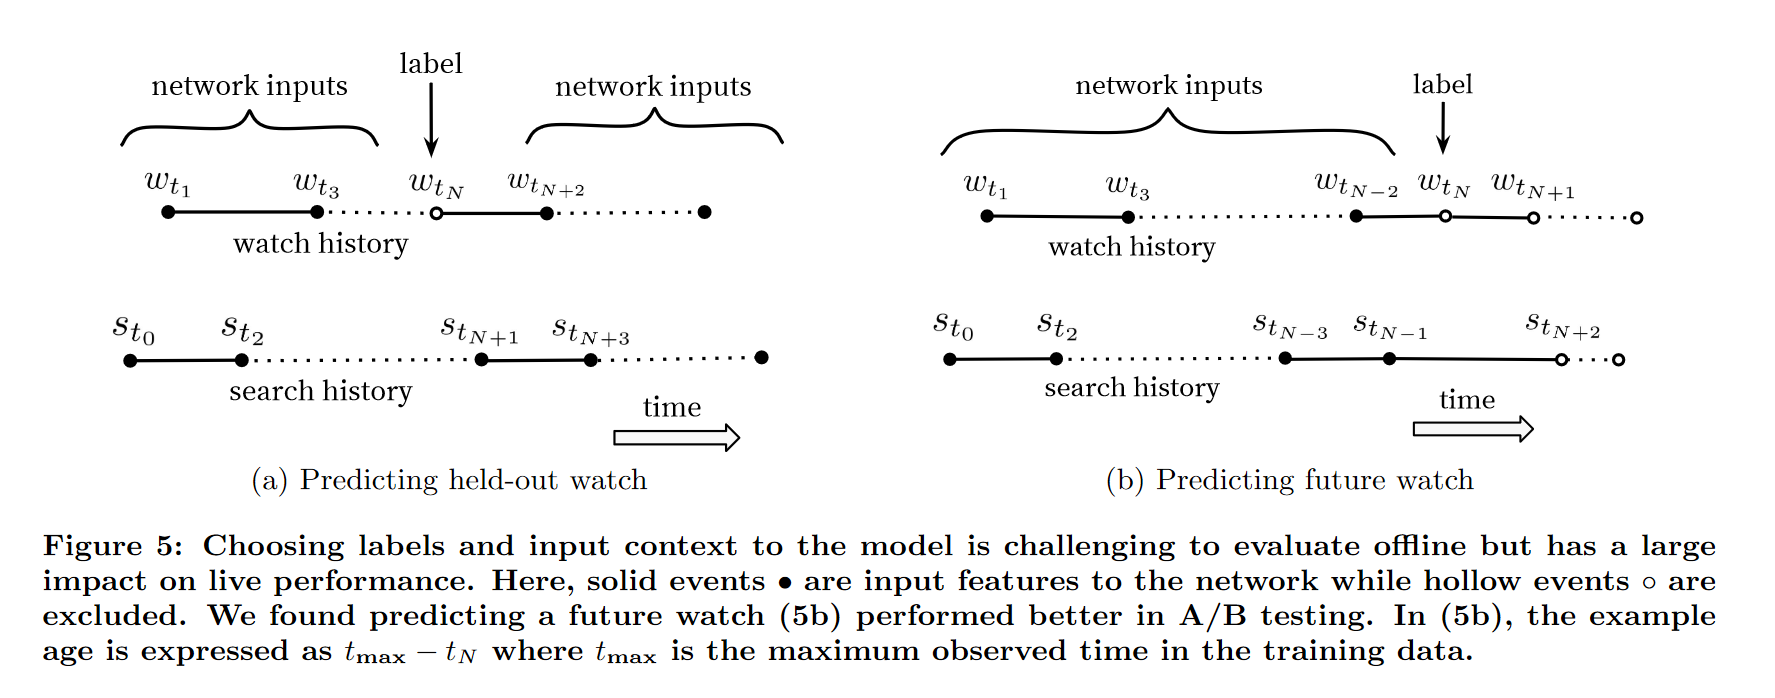

In [11]:
def extract_list_to_multiple_columns(dataset, column, max_len, padding):
  '''
  Sub-function used in prepare_train_test().
  Extract a column comprised of  lists (one list in one cell) to multiple column, one column for 
  one element in the list. And drop the original column.

  Arguments:
  -- dataset. Name of the dataset.
  -- column. Column name, in string form.
  -- max_len. An integer. The length of the list in each cell is varied. Limit the length to the max_len. Discard the
  rest.
  -- padding. Define what to pad to the cells whose length is less than max_len.
  '''

  i = 0
  for i in range(max_len):
      dataset[column +'_' + str(i)] = dataset[column].apply(lambda x: x[i] if i < len(x) else padding)
  dataset.drop(column, axis = 1, inplace = True)
      
  return dataset


def prepare_train_test(grouped, max_his_count, num_of_token):
  '''
    max_his_count           # the maximum number of watched videos. Tuneable.
    num_of_token     # tuneable. # The maximum length of title is 15. I limit the maximum length to 8. 
  '''
  # prepare the target labels.
  # Take the last-but-one label as the target label in training set. 
  # Take the last label as the target label in test set.
  grouped['last_but_one_label'] = grouped.movie_id.apply(lambda x: x[-2])
  grouped['last_label'] = grouped.movie_id.apply(lambda x: x[-1])

  train = grouped.copy()
  test = grouped.copy()

  # prepare the train set.
  train['movie_id'] = train['movie_id'].apply(lambda x: x[:-2] if (len(x) - 2) <= max_his_count else x[-(max_his_count+2):-2])
  train['search'] = train['search'].apply(lambda x: x[:-2] if (len(x) - 2) <= max_his_count else x[-(max_his_count+2):-2])
  train['his_count'] = train['movie_id'].apply(lambda x: len(x))
  train.drop('last_label', axis = 1, inplace = True)
  train = train.rename(columns={'last_but_one_label': 'label', 'movie_id': 'video_watches'})

  # flatten the DataFrame
  train = extract_list_to_multiple_columns(train, 'video_watches', max_his_count, padding = 0)   
  train = extract_list_to_multiple_columns(train, 'search', max_his_count, padding = [9999])
  
  j = 0
  while j < max_his_count:
      train = extract_list_to_multiple_columns(train, 'search_'+str(j), num_of_token, padding = 9999)  # Discard tokens after the 8th token and pad 0 to titles length less than 8.
      j += 1
      
  # prepare the test set.
  test = test[['user_id', 'last_label']]
  test = test.rename(columns={'last_label': 'label'})

  return train, test


train, test = prepare_train_test(grouped, max_his_count = 50, num_of_token = 8)    # max_his_count and num_of_token are tuneable

print(train.head(2))
print('Shape of train set:', train.shape)

   user_id       age  gender_F  ...  search_49_5  search_49_6  search_49_7
0        0 -2.298525       1.0  ...         9999         9999         9999
1        1  1.966729       0.0  ...         9999         9999         9999

[2 rows x 477 columns]
Shape of train set: (6040, 477)


The training set has 477 columns (What? We have so many input features for the NN? The answer is NO, we will reduce it through embedding later). They are:


> User_id

> Age

> Gender

> Occupation

> Video watches

> Search tokens

> Label

The test set has two columns: user_id and label.

In [12]:
print(test.head(2))
print('Shape of test set:', test.shape)

   user_id  label
0        0     25
1        1    133
Shape of test set: (6040, 2)


Now I construct the embedding matrix, each row of which is the embedding values for a word in the vocabulary. In the neural network model building process, I will build an word embedding layer whose size is the same as the embedding matrix, and set its weights equal to the embedding matrix. There are 4,053 words in the vocabulary, 97 of which are not in GloVe. For words present in GloVe, I fill their Glove embeddings in the embedding matrix. For the words not present in GloVe, I assign a vector of small random numbers as its embedding values.

In [16]:
def get_GloVe_dict(txt_file):
    '''
    Get a dictionary. The keys are the words and the values are the corresponding pre-trained embedding vectors.

    Argument: 
    -- txt_file: pre-trained GloVe embedding text file.

    Return:
    -- embeddings_dict: Dictionary. 
             The keys are the words and the values are the corresponding pre-trained embedding vectors.
    '''
    embeddings_dict = {}
    with open(txt_file, 'r', encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
            
    return embeddings_dict


def get_embedding_dct(index_to_word, pretrained_emb_dct, scale = .01):
    '''Get embedding dictionary. 
    The keys are index in the vocabulary and the values are pre-trained embedding values.
    If the keys are not present in the pretrained_emb_dct, random values of normal distribution(0, scale) are filled as embedding values.
    
    Arguments:
    -- index_to_word: a dictionary, e.g. {0: 'the', 1: 'multiple'}.
    -- pretrained_emb_dct: a dictionary of pre-trained word embeddings, e.g. {'the': (1D numpy array)}.
    -- scale: the scale of normal distribution.
    
    Output:
    -- emb_dct : a dictionary. 
                The keys are the indices of index_to_word and the values are the corresponding pre-trained 
                word embeddings, e.g. {0: (1D numpy array)}
    '''
    emb_dct = {}
    word_emb_dim = len(pretrained_emb_dct['the'])
    for index, word in index_to_word.items():
        emb_dct[index] = pretrained_emb_dct.get(word, np.random.normal(scale=scale, size=word_emb_dim))
        
    return emb_dct


def get_emb_matrix(emb_dct):
    '''
    Get embedding matrix for the words in the vocabulary. 
    The shape of the embedding matrix is (vocabulary size, embedding dimensions).

    Parameters
    ----------
    emb_dct : Dictionary.
        The keys are the indices of index_to_word and the values are the corresponding pre-trained word embeddings, e.g. {0: (1D numpy array)}

    Returns
    -------
    emb_matrix : Numpy matrix shaped (vocabulary size, embedding dimensions).
        Each row is the pre-trained word embedding values for a word in the vocabulary.

    '''
    voc_size = len(emb_dct)
    word_emb_dim = len(emb_dct[0])
    emb_matrix = np.zeros((voc_size, word_emb_dim))
    i = 0
    while i < voc_size:
        emb_matrix[i,:] = emb_dct[i]
        i += 1
        
    return emb_matrix

GloVe_dct = get_GloVe_dict("glove.6B.50d.txt")   

# construct embedding dictionary. 
emb_dct = get_embedding_dct(index_to_word, GloVe_dct, scale = .01)

# get embedding matrix, which will be used as the word embedding layer in the neural network. 
emb_matrix = get_emb_matrix(emb_dct)

print(emb_matrix.shape)

(4053, 50)


# 2. Model building and training.

In [17]:
# CUDA and DataLoader
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [18]:
class MyDataset(Dataset):

    def __init__(self, data):
        """
        Args:
            data: the dataset, in pandas DataFrame form.
        """
        self.df = data

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        ''' Retrieve instance(s) from data.
        
        Argument:
            -- idx: an integer of a list of integers.
            
        return: 
            -- A tuple storing (X,y), where X is a tensor shape (2,) and y is an integer.
        '''

        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        video_watches = self.df.filter(regex = 'video_watches')
        video_watches = video_watches.iloc[idx, :]
        video_watches = torch.tensor(video_watches.values, dtype = torch.long)
        
        search_tokens = self.df.filter(regex = 'search')
        search_tokens = search_tokens.iloc[idx, :]
        search_tokens = torch.tensor(search_tokens.values, dtype = torch.float32)
        
        context = self.df.iloc[idx, 1:25]
        context = torch.tensor(context.values)
        
        his_count = self.df.iloc[idx, self.df.columns == 'his_count']
        his_count = torch.tensor(his_count.values, dtype = torch.long)
        
        y = self.df.iloc[idx, self.df.columns == 'label']
        y = torch.tensor(y.values, dtype = torch.long)
        
        X = (video_watches, search_tokens, context, his_count)
        sample = (X, y)
        
        return sample

train_set = MyDataset(train)    
loader_train = DataLoader(train_set, batch_size=32, shuffle = True, num_workers = 0)  